In [ ]:
#codice principale del progetto (a partire da sintomi si arriva alla diagnosi)
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score


# Caricamento del dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    if "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    return df

# Funzione per pulire il testo
def clean_text(text):
    # Rendi il testo minuscolo
    text = text.lower()
    
    # Rimuovi punteggiatura e numeri
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    
    # Tokenizzazione
    tokens = word_tokenize(text)
    
    # Rimuovi stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatizzazione
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Riconcatena i token in una stringa
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Percorso del file
file_path = r"C:\Users\maria\OneDrive\Desktop\LIL_APPUNTI\Train_data.csv"
dataset = load_dataset(file_path)

# Pulizia del testo
dataset['cleaned_text'] = dataset['symptoms'].apply(clean_text)
# Capitalizzare la prima lettera della diagnosi
dataset['diagnosis'] = dataset['diagnosis'].str.capitalize()

# Dividi i dati in feature (X) e target (y)
X = dataset['cleaned_text']
y = dataset['diagnosis']

# Vettorizzazione del testo con TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Suddivisione in dati di training e testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Addestramento del modello
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

# Valutazione del modello
y_pred = model.predict(X_test)
print("\nReport di classificazione:")
print(classification_report(y_test, y_pred))
print(f"Accuratezza: {accuracy_score(y_test, y_pred):.2f}")


# Funzione per predire la diagnosi
def predict_diagnosis(user_input):
    # Pulizia e vettorizzazione dell'input utente
    cleaned_input = clean_text(user_input)
    user_input_tfidf = tfidf_vectorizer.transform([cleaned_input])
    
    # Predizione con il modello
    probabilities = model.predict_proba(user_input_tfidf)[0]
    
    # Ordina le diagnosi per probabilità decrescente
    sorted_indices = probabilities.argsort()[::-1]
    sorted_diagnoses = [(model.classes_[i], probabilities[i]) for i in sorted_indices]
    
    return sorted_diagnoses

# Interazione con l'utente
print("\nInserisci i tuoi sintomi:")
user_input = input()

# Predizione della diagnosi
predicted_diagnoses = predict_diagnosis(user_input)

# Visualizzazione del risultato
print("\nDiagnosi predette (ordinate per probabilità):")
for diagnosis, prob in predicted_diagnoses:
    print(f"- {diagnosis}: {prob:.2f}")





Report di classificazione:
                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00        10
                        Allergy       1.00      0.90      0.95        10
                      Arthritis       1.00      1.00      1.00        10
               Bronchial asthma       1.00      1.00      1.00        10
           Cervical spondylosis       1.00      1.00      1.00        10
                    Chicken pox       0.89      0.80      0.84        10
                    Common cold       1.00      1.00      1.00        10
                         Dengue       1.00      0.80      0.89        10
                       Diabetes       1.00      0.80      0.89        10
          Dimorphic hemorrhoids       1.00      1.00      1.00        10
                  Drug reaction       0.83      1.00      0.91        10
               Fungal infection       1.00      1.00      1.00        10
Gastroesophageal reflu

C:\Users\maria\AppData\Local\Temp\ipykernel_2264\1078885648.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=char_count_mean_per_diagnosis.index, y=char_count_mean_per_diagnosis.values, palette="viridis")


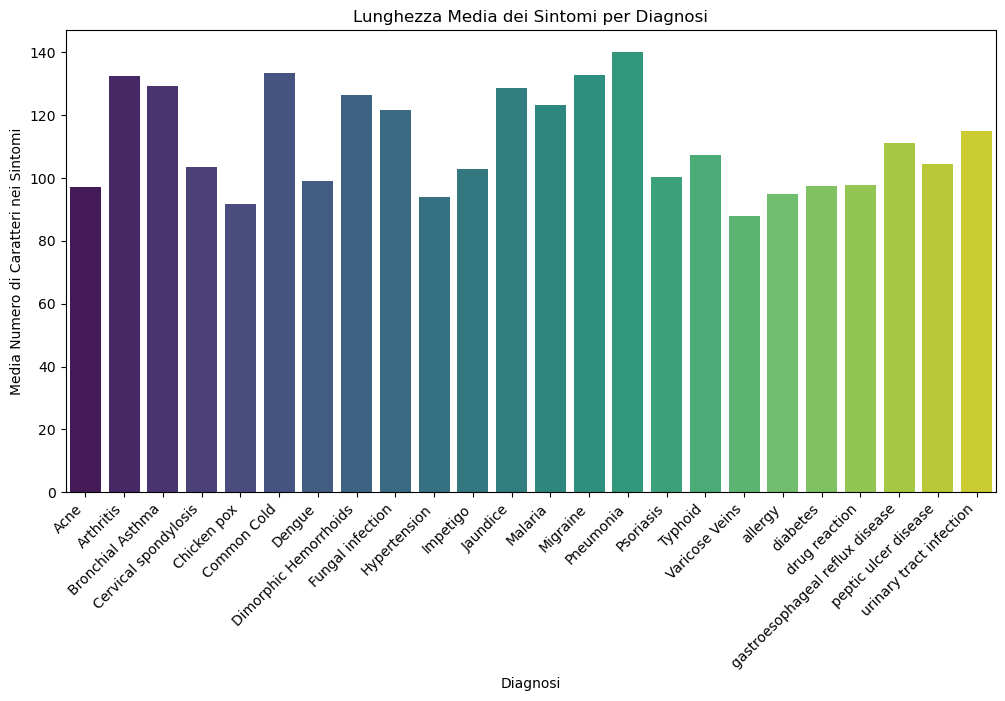

In [3]:
#creazione grafico per calcolare media dei caratteri per diagnosi con testo cleaned

# Calcolo del numero di caratteri per ogni sintomo pulito
dataset['char_count'] = dataset['cleaned_text'].apply(len)

# Calcolo della media del numero di caratteri per ogni diagnosi
char_count_mean_per_diagnosis = dataset.groupby('diagnosis')['char_count'].mean()

# Creazione del grafico
plt.figure(figsize=(12, 6))
sns.barplot(x=char_count_mean_per_diagnosis.index, y=char_count_mean_per_diagnosis.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Diagnosi")
plt.ylabel("Media Numero di Caratteri nei Sintomi")
plt.title("Lunghezza Media dei Sintomi per Diagnosi")
plt.show()

=== Performance del modello con testo RAW ===
Accuracy: 0.9458
Classification Report:
                                  precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                      Arthritis       0.91      1.00      0.95        10
               Bronchial Asthma       1.00      1.00      1.00        11
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       0.80      0.67      0.73        12
                    Common Cold       1.00      0.83      0.91        12
                         Dengue       1.00      0.75      0.86        12
          Dimorphic Hemorrhoids       1.00      1.00      1.00         7
               Fungal infection       1.00      1.00      1.00        13
                   Hypertension       1.00      1.00      1.00        12
                       Impetigo       0.92      1.00      0.96        11
                       Jaundice     

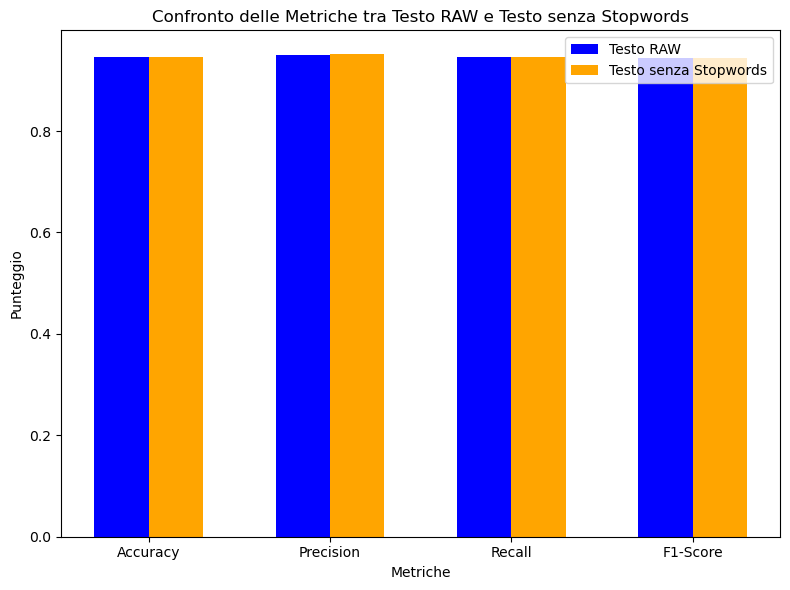

In [4]:
#differenza di performance mettendo a confronto il testo originale con il testo senza stopwords
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Funzione per rimuovere solo le stopwords senza altra pulizia
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    tokens = text.lower().split()
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Creare colonna con testo senza stopwords
dataset['text_no_stopwords'] = dataset['symptoms'].apply(remove_stopwords)

# Dividere i dati in training e test (80% - 20%)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(dataset['symptoms'], dataset['diagnosis'], test_size=0.2, random_state=42)
X_train_no_stopwords, X_test_no_stopwords, _, _ = train_test_split(dataset['text_no_stopwords'], dataset['diagnosis'], test_size=0.2, random_state=42)

# Vettorizzazione con TF-IDF per testo originale
tfidf_vectorizer_raw = TfidfVectorizer()
X_tfidf_raw_train = tfidf_vectorizer_raw.fit_transform(X_train_raw)
X_tfidf_raw_test = tfidf_vectorizer_raw.transform(X_test_raw)

# Vettorizzazione con TF-IDF per testo senza stopwords
tfidf_vectorizer_no_stopwords = TfidfVectorizer()
X_tfidf_no_stopwords_train = tfidf_vectorizer_no_stopwords.fit_transform(X_train_no_stopwords)
X_tfidf_no_stopwords_test = tfidf_vectorizer_no_stopwords.transform(X_test_no_stopwords)

# Addestramento del modello con il testo originale
model_raw = RandomForestClassifier(random_state=42)
model_raw.fit(X_tfidf_raw_train, y_train)

# Addestramento del modello con il testo senza stopwords
model_no_stopwords = RandomForestClassifier(random_state=42)
model_no_stopwords.fit(X_tfidf_no_stopwords_train, y_train)

# Predizioni
y_pred_raw = model_raw.predict(X_tfidf_raw_test)
y_pred_no_stopwords = model_no_stopwords.predict(X_tfidf_no_stopwords_test)

# Calcolare metriche di performance
accuracy_raw = accuracy_score(y_test, y_pred_raw)
precision_raw = precision_score(y_test, y_pred_raw, average='weighted')
recall_raw = recall_score(y_test, y_pred_raw, average='weighted')
f1_raw = f1_score(y_test, y_pred_raw, average='weighted')

accuracy_no_stopwords = accuracy_score(y_test, y_pred_no_stopwords)
precision_no_stopwords = precision_score(y_test, y_pred_no_stopwords, average='weighted')
recall_no_stopwords = recall_score(y_test, y_pred_no_stopwords, average='weighted')
f1_no_stopwords = f1_score(y_test, y_pred_no_stopwords, average='weighted')

# Stampare classification report
print("=== Performance del modello con testo RAW ===")
print(f"Accuracy: {accuracy_raw:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_raw))

print("\n=== Performance del modello con testo SENZA STOPWORDS ===")
print(f"Accuracy: {accuracy_no_stopwords:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_no_stopwords))

# Grafico confronto metriche
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
raw_scores = [accuracy_raw, precision_raw, recall_raw, f1_raw]
no_stopwords_scores = [accuracy_no_stopwords, precision_no_stopwords, recall_no_stopwords, f1_no_stopwords]

x = np.arange(len(metrics))
width = 0.3  # Larghezza delle barre

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, raw_scores, width, label='Testo RAW', color='blue')
plt.bar(x + width/2, no_stopwords_scores, width, label='Testo senza Stopwords', color='orange')

plt.xlabel('Metriche')
plt.ylabel('Punteggio')
plt.title('Confronto delle Metriche tra Testo RAW e Testo senza Stopwords')
plt.xticks(ticks=x, labels=metrics)
plt.legend()

plt.tight_layout()
plt.show()



=== Performance del modello con testo RAW ===
Accuracy: 0.9500
Classification Report:
                                  precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         7
                        Allergy       1.00      1.00      1.00        10
                      Arthritis       0.91      1.00      0.95        10
               Bronchial asthma       1.00      1.00      1.00        11
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       0.80      0.67      0.73        12
                    Common cold       1.00      0.83      0.91        12
                         Dengue       1.00      0.75      0.86        12
                       Diabetes       1.00      0.82      0.90        11
          Dimorphic hemorrhoids       1.00      1.00      1.00         7
                  Drug reaction       0.88      1.00      0.93         7
               Fungal infection     

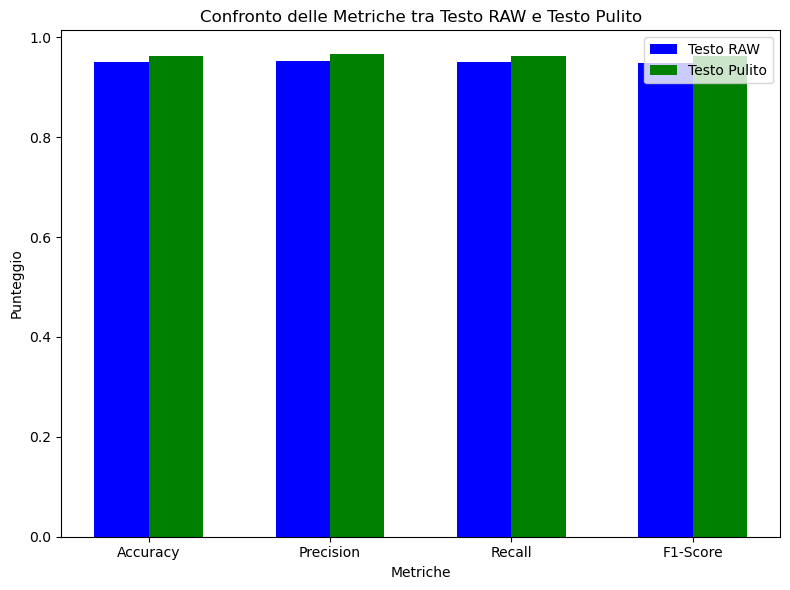

In [5]:
#differenza di performance mettendo a confronto il testo originale con il testo pulito del tutto(lemmatizzazione,tokenizzazione, ecc..)

# Suddividere il dataset in training e test (80% - 20%)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(dataset['symptoms'], dataset['diagnosis'], test_size=0.2, random_state=42)
X_train_cleaned, X_test_cleaned, _, _ = train_test_split(dataset['cleaned_text'], dataset['diagnosis'], test_size=0.2, random_state=42)

# Vettorizzazione con TF-IDF per testo originale
tfidf_vectorizer_raw = TfidfVectorizer()
X_tfidf_raw_train = tfidf_vectorizer_raw.fit_transform(X_train_raw)
X_tfidf_raw_test = tfidf_vectorizer_raw.transform(X_test_raw)

# Vettorizzazione con TF-IDF per testo pulito
tfidf_vectorizer_cleaned = TfidfVectorizer()
X_tfidf_cleaned_train = tfidf_vectorizer_cleaned.fit_transform(X_train_cleaned)
X_tfidf_cleaned_test = tfidf_vectorizer_cleaned.transform(X_test_cleaned)

# Addestramento del modello con il testo originale
model_raw = RandomForestClassifier(random_state=42)
model_raw.fit(X_tfidf_raw_train, y_train)

# Addestramento del modello con il testo pulito
model_cleaned = RandomForestClassifier(random_state=42)
model_cleaned.fit(X_tfidf_cleaned_train, y_train)

# Predizioni
y_pred_raw = model_raw.predict(X_tfidf_raw_test)
y_pred_cleaned = model_cleaned.predict(X_tfidf_cleaned_test)

# Calcolare metriche di performance
accuracy_raw = accuracy_score(y_test, y_pred_raw)
precision_raw = precision_score(y_test, y_pred_raw, average='weighted')
recall_raw = recall_score(y_test, y_pred_raw, average='weighted')
f1_raw = f1_score(y_test, y_pred_raw, average='weighted')

accuracy_cleaned = accuracy_score(y_test, y_pred_cleaned)
precision_cleaned = precision_score(y_test, y_pred_cleaned, average='weighted')
recall_cleaned = recall_score(y_test, y_pred_cleaned, average='weighted')
f1_cleaned = f1_score(y_test, y_pred_cleaned, average='weighted')


# Stampare classification report
print("=== Performance del modello con testo RAW ===")
print(f"Accuracy: {accuracy_raw:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_raw))

print("\n=== Performance del modello con testo PULITO ===")
print(f"Accuracy: {accuracy_cleaned:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_cleaned))

# Grafico confronto metriche
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
raw_scores = [accuracy_raw, precision_raw, recall_raw, f1_raw]
cleaned_scores = [accuracy_cleaned, precision_cleaned, recall_cleaned, f1_cleaned]

x = np.arange(len(metrics))
width = 0.3  # Larghezza delle barre

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, raw_scores, width, label='Testo RAW', color='blue')
plt.bar(x + width/2, cleaned_scores, width, label='Testo Pulito', color='green')

plt.xlabel('Metriche')
plt.ylabel('Punteggio')
plt.title('Confronto delle Metriche tra Testo RAW e Testo Pulito')
plt.xticks(ticks=x, labels=metrics)
plt.legend()

plt.tight_layout()
plt.show()

